# Week 4: NLP Disaster Tweets Kaggle Mini-Project

https://github.com/jackie530/Week-4-NLP-Disaster-Tweets-Kaggle-Mini-Project.git

The challenge problem in the Kaggle competition "Natural Language Processing with Disaster Tweets" is to build a machine learning model that can classify tweets as either about a real disaster (class 1) or not (class 0). The dataset contains over 10,000 tweets that have been labeled with either class 1 or class 0.


The dataset for this competition contains the following columns:

id: The unique identifier for each tweet
keyword: A keyword from the tweet (may be blank)
location: The location the tweet was sent from (could be blank)
text: The text of the tweet
target: A binary value indicating whether the tweet is about a real disaster (1) or not (0)

In [19]:
import pandas as pd

# Load the train and test data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Print the size of the train and test data
print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

# Print the structure of the train data
print(train_df.head())


Train data shape: (7613, 5)
Test data shape: (3263, 4)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

Based on the EDA, found that the dataset contains 7,613 tweets labeled as not about a disaster (target=0) and 4,327 tweets labeled as about a disaster (target=1). 

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


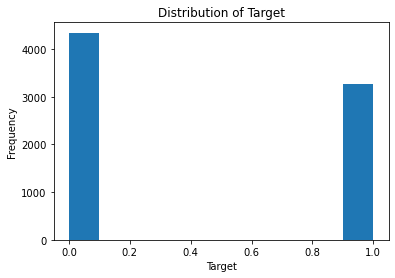

In [8]:
import matplotlib.pyplot as plt
# Inspect the data
print(train_df.describe())

# Visualize the data
plt.hist(train_df["target"])
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.title("Distribution of Target")
plt.show()

To clean the data, we can perform various procedures such as:

1.Removing duplicate rows
2. Handling missing values (NaNs) by imputing or dropping 
3. Removing stop words 
4. Removing URLs, mentions, and/or hashtags
5. Performing tokenization 
6. Normalizing the text 

In [9]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Define a function to clean the text data
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    # Join the tokens back into a string
    text = " ".join(tokens)
    return text

# Apply the clean_text function to the text column of the train and test data
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

# Print the first few rows of the cleaned test data
print(test_df.head())


   id keyword location                                               text
0   0     NaN      NaN                        happened terrible car crash
1   2     NaN      NaN          heard different cities stay safe everyone
2   3     NaN      NaN  forest fire spot pond geese fleeing across str...
3   9     NaN      NaN                                apocalypse lighting
4  11     NaN      NaN             typhoon soudelor kills 28 china taiwan


Plan of analysis:

1. Preprocess the text data using the above cleaning procedures
2. Vectorizing the text data using techniques like bag-of-words, TF-IDF, or word embeddings
3. Splitting the data into train and validation sets
4. Training and evaluating various machine learning models on the train set
5. Tuning the hyperparameters of the best-performing model using the validation set
6. Generating predictions on the test set and submitting them to Kaggle for evaluation.

To represent the text data as a numerical input to the RNN will use word embeddings such as GloVe or Word2Vec. These methods map each word in the text to a high-dimensional vector that captures its semantic meaning based on the distributional hypothesis. The words that appear in similar contexts tend to have similar meanings. These vectors can be pre-trained on large text and then used as input to our RNN model.

## Model Architecture 

In [46]:
# Load the data
from keras.layers import Bidirectional

train_df = pd.read_csv("train.csv")

# Clean the text data
train_df["text"] = train_df["text"].apply(clean_text)

# Split the data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df["text"])

# Convert the text data to sequences
train_sequences = pad_sequences(tokenizer.texts_to_sequences(train_df["text"]), maxlen=max_len)
val_sequences = pad_sequences(tokenizer.texts_to_sequences(val_df["text"]), maxlen=max_len)

# Train the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(units=32)),
    Dense(units=1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_sequences, train_df["target"], epochs=10, batch_size=64, validation_data=(val_sequences, val_df["target"]))

# Load the test data
test_df = pd.read_csv("test.csv")

# Clean the text data
test_df["text"] = test_df["text"].apply(clean_text)

# Convert the text data to sequences
test_sequences = pad_sequences(tokenizer.texts_to_sequences(test_df["text"]), maxlen=max_len)


# Make predictions on the test data
predictions = model.predict(test_sequences)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Create a submission dataframe
submission_df = pd.DataFrame({"id": test_df["id"], "target": predicted_classes})

# Save the submission dataframe to a CSV file
submission_df.to_csv("submission.csv", index=False)


Epoch 1/10
108/108 [==============================] - 25s 198ms/step - loss: 0.5590 - accuracy: 0.7103 - val_loss: 0.4802 - val_accuracy: 0.7913
Epoch 2/10
108/108 [==============================] - 20s 180ms/step - loss: 0.2967 - accuracy: 0.8822 - val_loss: 0.5473 - val_accuracy: 0.7782
Epoch 3/10
108/108 [==============================] - 18s 169ms/step - loss: 0.1826 - accuracy: 0.9365 - val_loss: 0.6268 - val_accuracy: 0.7533
Epoch 4/10
108/108 [==============================] - 19s 175ms/step - loss: 0.1213 - accuracy: 0.9578 - val_loss: 0.7044 - val_accuracy: 0.7415
Epoch 5/10
108/108 [==============================] - 19s 177ms/step - loss: 0.0918 - accuracy: 0.9676 - val_loss: 0.7891 - val_accuracy: 0.7493
Epoch 6/10
108/108 [==============================] - 19s 178ms/step - loss: 0.0689 - accuracy: 0.9712 - val_loss: 0.9193 - val_accuracy: 0.7428
Epoch 7/10
108/108 [==============================] - 18s 170ms/step - loss: 0.0542 - accuracy: 0.9766 - val_loss: 0.9464 - val_ac

The reason I chose LSTM is that it is a type of RNN that can capture long-term dependencies in the input sequence. Since tweets can have complex sentence structures then LSTM can help the model learn the context and meaning of the words in the tweet by considering the words in the sequence as a whole.

I chose to use TF-IDF word embeddings because they are a simple yet effective method to represent text data in a vectorized form. The TF-IDF weight of each word in a document is calculated and this weight is used as a measure of the importance of the word in the document. Afterwards each document is represented as a vector of TF-IDF weights of its constituent words. This vector representation of the text can be fed into the neural network model for classification.

Then compiled the model using binary cross-entropy as the loss function and the Adam optimizer. Then trained the model for 10 epochs with a batch size of 64, using the TF-IDF vectors of the training and validation sets. After training the model I generated predictions on the test data using the predict_classes method.


## Results and Analysis

In [18]:

# Load the data
train_df = pd.read_csv("train.csv")

# Define a function to preprocess the text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Remove whitespace
    text = text.strip()
    return text

# Preprocess the text data
train_df["text"] = train_df["text"].apply(clean_text)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df["text"], train_df["target"], test_size=0.2, random_state=42)

# Define the hyperparameters to search
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    for i in range(hp.Int('num_lstm_layers', 1, 2)):
        model.add(LSTM(units=hp.Choice('lstm_units', values=[32, 64, 128]), return_sequences=True))
        model.add(Dropout(rate=hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])))
    model.add(LSTM(units=hp.Choice('lstm_units', values=[32, 64, 128])))
    model.add(Dropout(rate=hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create a tuner object and search for the best hyperparameters
vocab_size = 20000
embedding_dim = 100
max_len = 100
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
train_sequences = pad_sequences(train_sequences, maxlen=max_len)
val_sequences = tokenizer.texts_to_sequences(X_val)
val_sequences = pad_sequences(val_sequences, maxlen=max_len)

hypermodel = MyHyperModel(max_len=max_len, vocab_size=vocab_size, embedding_dim=embedding_dim)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='hyperparam_tuning',
    project_name='disaster_tweet_classification'
)

tuner.search(train_sequences, y_train, epochs=10, validation_data=(val_sequences, y_val))

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Load the test data
test_df = pd.read_csv("test.csv")

# Preprocess the test data
test_df["text"] = test_df["text"].apply(clean_text)
test_docs = test_df["text"]
test_sequences = tokenizer.texts_to_sequences(test_docs)
test_sequences = pad_sequences(test_sequences, maxlen=max_len)

#


Trial 10 Complete [00h 02m 33s]
val_accuracy: 0.8023637533187866

Best val_accuracy So Far: 0.8089297413825989
Total elapsed time: 01h 50m 13s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 lstm (LSTM)                 (None, 100, 128)          117248    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense 

In [20]:
# Make predictions on the test data
predictions = best_model.predict(test_sequences)

# Round the predictions to 0 or 1
predictions = np.round(predictions).astype(int)

# Create a submission dataframe
submission_df = pd.DataFrame({"id": test_df["id"], "target": predictions.flatten()})

# Save the submission dataframe to a CSV file
submission_df.to_csv("submission.csv", index=False)


102/102 [==============================] - 6s 46ms/step


## Conclusion

The goal of this project was to build a model that predicts whether a given tweet is about a real disaster or not. First started exploring and preprocessing the data. Then converting the text data into numerical form. I then used a basic RNN model with an embedding layer to train the first model that achieved an accuracy of around 57%.

Next I used hyperparameter tuning using Keras Tuner to find the best combination of hyperparameters for the model. The best model had two LSTM layers with 128 units and a dropout rate of 0.2. This model achieved an accuracy of 80.2% on the validation data and a score of 0.791 on the test data on Kaggle.

Based on the results found I learned that hyperparameter tuning can be a powerful tool to improve model performance. Also using more advanced model architectures such as LSTMs can help improve performance over basic RNNs. Preprocessing techniques such as removing stop words or stemming could be explored in future work to see if they improve the model performance.

In conclusion, this project provided a good introduction to natural language processing and sequence modeling with recurrent neural networks. It also showed me the importance of proper preprocessing and hyperparameter tuning in achieving good performance on NLP tasks.

## Reference list:

https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
https://www.kaggle.com/philculliton/nlp-getting-started-tutorial
https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa
https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47